In [1]:
## Importing standards libraries

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
#import torch


## Importing libraries for the Gaussian Mixture Model

from scipy.stats import multivariate_normal
from scipy.stats import norm
import seaborn as sns


## Convergence metrics

from scipy.stats import wasserstein_distance
from scipy.stats import entropy # KL-divergence


## Import functions for the experiment : 

from experiment_functions import *
from IPLA_Exp_Functions import *
from IPLA_functions_MMLE_V2 import *


### Setting of the Experiment

In this Notebook, we consider the same setting as previously with the same Latent Variable Model :


- $\mathbf{y} = \theta^{*}\mathbf{x} + \mathbf{z}$ where:
- $\mathbf{y} \in \mathbb{R}$ is the observed data,
- $\theta^{*} \in \mathbb{R}^{2}$ is the "ground truth" parameter that links the latent variables and the observed data.

To generate $\mathbf{y}$, the observed data, we first draw $x^{*} \sim p_{0}$ and set $\mathbf{y} := \theta^{*}x + \mathbf{z}$, where $\mathbf{z} \sim \mathcal{N}(0, \sigma_y^{2})$ 

For a given dimension $d_x$, we consider the prior distribution $p_0$, which is a mixture of 25 Gaussian random variables. The components have mean $\mu_{i,j} := (8i, 8j, \ldots, 8i, 8j) \in \mathbb{R}^{d_x}$ for $(i, j) \in \{-2, -1, 0, 1, 2\}^2$ and unit variance. We have set the associated unnormalized weights $\omega_{i,j} = 1.0$. This choice of Parametric Model is convenient because it allows the Posterior Distribution to stay in the same parametric family of distribution : it is a Gaussian Mixture. 

The joint density of the variables, $ p_\theta(x, y) $, is given by : $ p_\theta(x, y) = p_\theta(y \mid x) p_{0}(x) $, where : 
- $ p_\theta(y \mid x) = \mathcal{N}(y \mid \theta^{*}x, \sigma_y^2)$
- $ p_{0}(x) = \frac{1}{K} \sum_{k=1}^K \mathcal{N}(x \mid \mu_k, I) $

But here, we would like to estimate the Maximum Marginal Likelihood of the model given one observations $y_{obs} \in \mathbb{R}$, which correspond to : 

\begin{equation}
\theta^\ast \in \arg \max_{\theta \in \mathbb{R}^{d_\theta}} \log p_\theta(y),
\end{equation}

In order to do that, we implement several algorithms and compare their efficiency through different examples : 
- Particle Gradient Descent
- Interacting Particle Langevin Algorithm from the "[Interacting Particle Langevin Algorithm for Maximum Marginal
Likelihood Estimation](https://arxiv.org/pdf/2303.13429)"
- Interacting Particle Langevin Algorithm with Dilation Path, inspired from the idea of a convolutional path for ULA in "[A Practical Diffusion Path for Sampling](https://arxiv.org/abs/2406.14040)"

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
First, we have to generate the observation $y_{obs}$ as mentionned in the article. For that we generate : 
- Parameters of the prior distribution
- A sample from the prior distribution to initialize the position of the particles
- Chose the 'true' parameter &\theta& of the model
- Generate the observation $y_{obs}$ 

Shape of means array: (25, 10)
Unit Covariance Matrix: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Weights vector : [0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04
 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04]


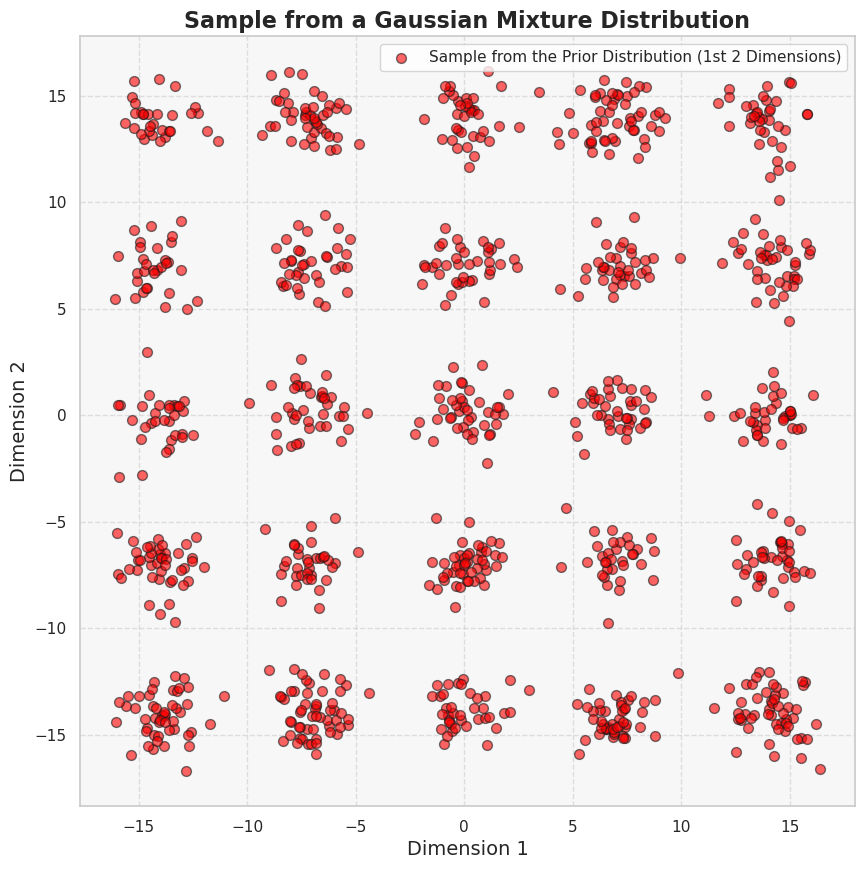

In [240]:
params_prior = gen_prior_param(10, 15)

x_start = sample_prior_dx(1000, params_prior[0], params_prior[1], params_prior[2])
plot_sample_dx(x_start, desc_sample_1 = 'Sample from the Prior Distribution (1st 2 Dimensions)')

In [650]:
x_star = sample_prior_dx(1, params[0], params[1], params[2])

#theta_star = np.random.uniform(0, 1, 10)
theta_star = np.tile([-1, 1], 5)

y_obs_dx = generate_obs_dx(x_star, theta_star, 0.1)
y_obs_dx

array([-52.57532658])

Here we simply plot the true posterior Distribution of the model given the observation and $\theta$

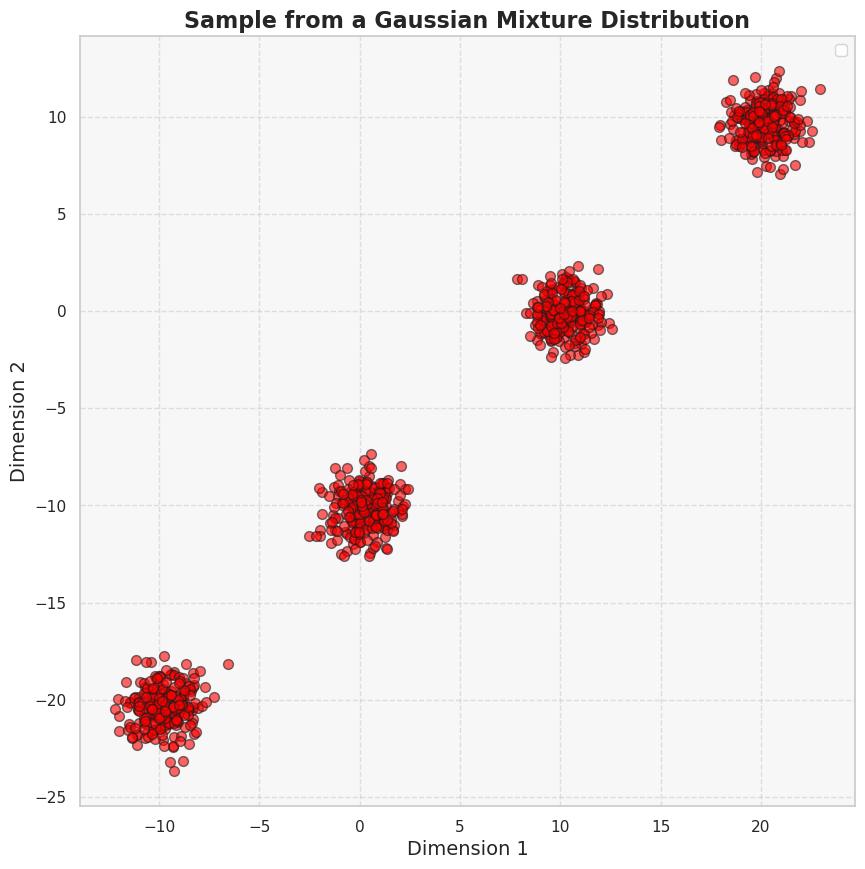

In [651]:
centers_posteriori, covariances_posteriori, weights_posteriori = post_params_dx(theta_star, 0.1, params[0], params[1], params[2], y_obs_dx)

sample_post = sample_prior_dx(1000, centers_posteriori, covariances_posteriori, weights_posteriori)

plot_sample_dx(sample_post)

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Here is the function that computes the gradient our the log-density of the joint distribution, w.r.t parameter theta :

The joint density of the variables, $ p_\theta(x, y) $, is given by : $ p_\theta(x, y) = p_\theta(y \mid x) p_{0}(x) $. We are able to compute the gradient of $ p_\theta(x, y) $ with respect to the parameter $\theta$ (CHECK "-"):

\begin{equation}
- \nabla_{\theta} \log p_{\theta}(x, y) = \frac{1}{\sigma_y^2} (y - \theta x) x^T
\end{equation}

In [432]:
def grad_theta_GM(x_t, theta_t, y_obs, sigma_y):
    """
    This function can compute the gradient of the log density of our LVM (potential function), with respect to the parameters theta. 
    """

    return (-1 / sigma_y**2) * (y_obs - np.dot(x_t, theta_t.T))[:, np.newaxis] * x_t

### Particle Gradient Descent 

**Inputs**: 
- Step size $ h $
- Number of steps $ K $
- Number of particles $ N $
- Initial particles $ X_0^1, \dots, X_0^N $
- Initial parameter estimates $ \theta_0 $

**Algorithm**:

1. For $ k = 0, \dots, K-1 $ do:
   
   a. **Update the parameter estimates**:
   
      $
      \theta_{k+1} = \theta_k + \frac{h}{N} \sum_{n=1}^{N} \nabla_{\theta} \ell(\theta_k, X_k^n)
      $
   
   b. **Update the particles**: for all $ n = 1, \dots, N $,

      $
      X_{k+1}^n = X_k^n + h \nabla_{x} \ell(\theta_k, X_k^n) + \sqrt{2h} W_k^n
      $
      
      where $ W_k^1, \dots, W_k^N $ are i.i.d. random variables drawn from $ N(0, \mathbf{I}_{D_x}) $.

5. Return $ (\theta_k, q_k := \frac{1}{N} \sum_{n=1}^{N} \delta_{X_k^n})_{k=0}^{K} $


In [433]:

def PGD_dx(nb_particles, nb_iter, step_size, centers_prior, covariances_prior, weights_prior, theta_0, sigma_y, y_obs, plot = False, plot_true_theta = None) : 
    """
    This function executes the Particle Gradient Descent in the context of our experiment. Given :
    - The number of particles
    - The number of iterations
    - The step size
    - Parameters of the prior distribution
    - The observed data point "y"
    - The initializing theta_0
    """

    theta_t = theta_0

    dx = theta_0.shape[0]

    sample = sample_prior_dx(nb_particles, centers_prior, covariances_prior, weights_prior)

    time_SDE = 0

    theta_traj = np.zeros((nb_iter, dx))

    for i in tqdm(range(nb_iter)) : 

        #We don't need to compute the parameters of the posteriori distribution given the updated theta because we use another formula
        #centers_post, covariances_post, weights_post = post_params(theta_t, sigma_y, centers_prior, covariances_prior, weights_prior)

        time_SDE += step_size

        ## on prend le gradient selon x de la posterior actualisée avec theta_t et qui est aussi une mixture Gaussienne
        grad = ((1/sigma_y**2) * theta_t[:, np.newaxis] * (y_obs - np.dot(theta_t, sample.T))).T 

        grad += grad_multimodal_opti(sample, weights_prior, centers_prior, covariances_prior) 

        grad_update = step_size * grad
        
        #Noise
        noise =  np.sqrt(2 * step_size) * np.random.randn(nb_particles, dx)

        sample += grad_update + noise #Warning sign

        #MAJ THETA we need a fct that compute gradient of the potential wrt to theta

        grad_theta = grad_theta_GM(sample, theta_t, y_obs, sigma_y) #renvoie un vecteur avec tous les gradients

        grad_theta_update = np.sum(grad_theta, axis = 0) ## ON MULTIPLIE CHAQUE PARTICLE A SON PAS SPECIFIQUE

        theta_t = theta_t - (step_size / nb_particles) * grad_theta_update 

        theta_traj[i] = theta_t

        if np.sum(np.isnan(sample)) // dx > 850:

            print('Too many NaN in the sample')
            
            return sample, theta_t, theta_traj

    if plot : 

        centers_post, covariances_post, weights_post = post_params_dx(plot_true_theta, sigma_y, centers_prior, covariances_prior, weights_prior, y_obs)
        
        sample_post = sample_prior_dx(1000, centers_post, covariances_post, weights_post)
        
        plot_sample_dx(sample, "PDG Sample", sample_post, "True Posterior Sample")

        #plot
        plt.figure(figsize=(10, 8))

        plt.plot(theta_traj[:, 0], theta_traj[:, 1], 'o-', markersize=4, label='Theta Trajectory')

        for i in range(1, len(theta_traj)):

            plt.arrow(theta_traj[i-1, 0], theta_traj[i-1, 1], 
                    theta_traj[i, 0] - theta_traj[i-1, 0], 
                    theta_traj[i, 1] - theta_traj[i-1, 1], 
                    head_width=0.05, head_length=0.1, fc='blue', ec='blue')
            
        plt.scatter(plot_true_theta[0], plot_true_theta[1], color='red', s=100, zorder=5, label='True Theta (1st 2 Dimensions)')
        plt.text(plot_true_theta[0], plot_true_theta[1], s = f"({plot_true_theta[0]}, {plot_true_theta[1]})" , fontsize=12, verticalalignment='bottom', horizontalalignment='right')

        plt.xlabel('Theta Dimension 1')
        plt.ylabel('Theta Dimension 2')
        plt.title(f'Trajectory of Theta in 2D - Step Size {step_size}')
        plt.legend()
        plt.grid(True)
        plt.show() 

    print(f'At the end, the number of NaN in the final sample of particle is {np.sum(np.isnan(sample)) // dx}')

    return sample, theta_t, theta_traj

We initialize $\theta_0$ = $(0,0, ...,0,0)$. 

  0%|          | 5/8000 [00:00<01:59, 67.17it/s]


Too many NaN in the sample


  0%|          | 5/8000 [00:00<02:00, 66.39it/s]


Too many NaN in the sample


  0%|          | 5/8000 [00:00<01:54, 69.77it/s]


Too many NaN in the sample


100%|██████████| 8000/8000 [01:34<00:00, 84.57it/s] 


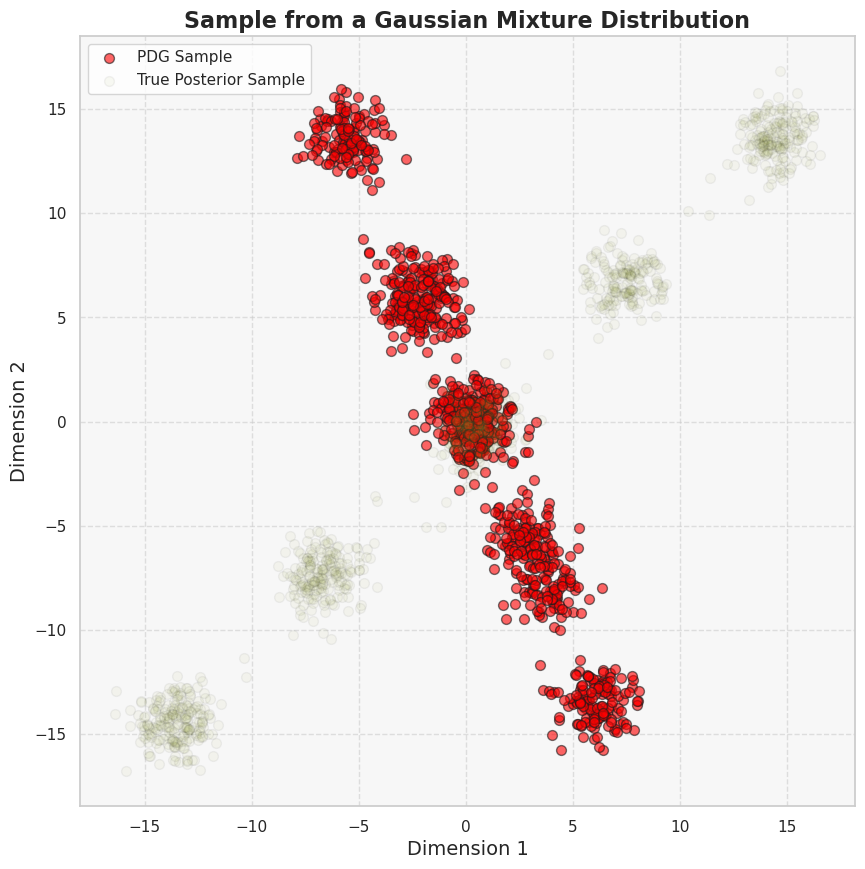

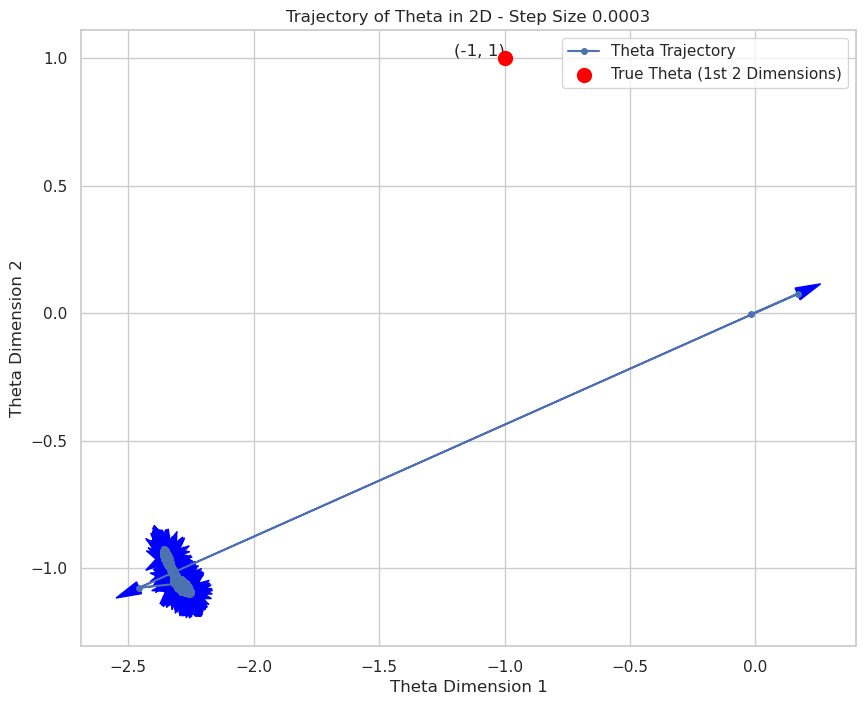

At the end, the number of NaN in the final sample of particle is 0


  0%|          | 5/8000 [00:00<02:17, 58.28it/s]


Too many NaN in the sample


  0%|          | 5/8000 [00:00<02:04, 64.26it/s]


Too many NaN in the sample


  0%|          | 5/8000 [00:00<01:52, 71.21it/s]


Too many NaN in the sample


  0%|          | 5/8000 [00:00<02:10, 61.39it/s]


Too many NaN in the sample


  0%|          | 5/8000 [00:00<02:14, 59.29it/s]


Too many NaN in the sample


  0%|          | 5/8000 [00:00<01:46, 75.35it/s]


Too many NaN in the sample


  0%|          | 5/8000 [00:00<01:53, 70.38it/s]

Too many NaN in the sample
[nan nan nan nan nan nan nan nan nan nan]


In [467]:
## Initialization of theta at origin
theta_0 = np.zeros(10)
sigma_y = 0.1

final_sample, theta_estimated, theta_traj = PGD_dx(1000, 8000, 0.0003, params_prior[0], params_prior[1], params_prior[2], theta_0, sigma_y, y_obs_dx, plot = True, plot_true_theta = theta_star)

print(theta_estimated)

### Interacting Particle Langevin Algorithm 

**Inputs**: 
- Step size $ h $
- Number of steps $ K $
- Number of particles $ N $
- Initial particles $ X_0^1, \dots, X_0^N $
- Initial parameter estimates $ \theta_0 $

**Algorithm**:

1. For $ k = 0, \dots, K-1 $ do:
   
   a. **Update the parameter estimates**:
   
      $
      \theta_{k+1} = \theta_k + \frac{h}{N} \sum_{n=1}^{N} \nabla_{\theta} \ell(\theta_k, X_k^n) + \sqrt{\frac{2h}{N}} W_k^0
      $
   
   b. **Update the particles**: for all $ n = 1, \dots, N $,

      $
      X_{k+1}^n = X_k^n + h \nabla_{x} \ell(\theta_k, X_k^n) + \sqrt{2h} W_k^n
      $
      
      where $ W_k^1, \dots, W_k^N $ are i.i.d. random variables drawn from $ N(0, \mathbf{I}_{D_x}) $.

5. Return $ (\theta_k, q_k := \frac{1}{N} \sum_{n=1}^{N} \delta_{X_k^n})_{k=0}^{K} $


In [344]:

def IPLA_dx(nb_particles, nb_iter, step_size, centers_prior, covariances_prior, weights_prior, theta_0, sigma_y, y_obs, plot = False, plot_true_theta = None) : 
    """
    This function executes the Particle Gradient Descent in the context of our experiment. Given :
    - The number of particles
    - The number of iterations
    - The step size
    - Parameters of the prior distribution
    - The observed data point "y"
    - The initializing theta_0
    """

    theta_t = theta_0

    dx = theta_0.shape[0]

    sample = sample_prior_dx(nb_particles, centers_prior, covariances_prior, weights_prior)

    time_SDE = 0

    theta_traj = np.zeros((nb_iter, dx))

    for i in tqdm(range(nb_iter)) : 

        #We don't need to compute the parameters of the posteriori distribution given the updated theta because we use another formula
        #centers_post, covariances_post, weights_post = post_params(theta_t, sigma_y, centers_prior, covariances_prior, weights_prior)

        time_SDE += step_size

        ## on prend le gradient selon x de la posterior actualisée avec theta_t et qui est aussi une mixture Gaussienne
        grad = ((1/sigma_y**2) * theta_t[:, np.newaxis] * (y_obs - np.dot(theta_t, sample.T))).T 

        grad += grad_multimodal_opti(sample, weights_prior, centers_prior, covariances_prior) 

        grad_update = step_size * grad
        
        #Noise
        noise =  np.sqrt(2 * step_size) * np.random.randn(nb_particles, dx)

        sample += grad_update + noise #Warning sign

        #MAJ THETA we need a fct that compute gradient of the potential wrt to theta

        grad_theta = grad_theta_GM(sample, theta_t, y_obs, sigma_y) #renvoie un vecteur avec tous les gradients

        grad_theta_update = np.sum(grad_theta, axis = 0) ## ON MULTIPLIE CHAQUE PARTICLE A SON PAS SPECIFIQUE

        theta_noise = np.sqrt(2 * step_size / nb_particles) * np.random.randn(dx)

        theta_t = theta_t - (step_size / nb_particles) * grad_theta_update + theta_noise

        theta_traj[i] = theta_t

        if np.sum(np.isnan(sample)) // dx > 850:

            print('Too many NaN in the sample')
            
            return sample, theta_t, theta_traj

    if plot : 

        centers_post, covariances_post, weights_post = post_params_dx(plot_true_theta, sigma_y, centers_prior, covariances_prior, weights_prior, y_obs)
        
        sample_post = sample_prior_dx(1000, centers_post, covariances_post, weights_post)
        
        plot_sample_dx(sample, "IPLA Sample", sample_post, "True Posterior Sample")

        #plot
        plt.figure(figsize=(10, 8))

        plt.plot(theta_traj[:, 0], theta_traj[:, 1], 'o-', markersize=4, label='Theta Trajectory')

        for i in range(1, len(theta_traj)):

            plt.arrow(theta_traj[i-1, 0], theta_traj[i-1, 1], 
                    theta_traj[i, 0] - theta_traj[i-1, 0], 
                    theta_traj[i, 1] - theta_traj[i-1, 1], 
                    head_width=0.05, head_length=0.1, fc='blue', ec='blue')
            
        plt.scatter(plot_true_theta[0], plot_true_theta[1], color='red', s=100, zorder=5, label='True Theta (1st 2 Dimensions)')
        plt.text(plot_true_theta[0], plot_true_theta[1], s = f"({plot_true_theta[0]}, {plot_true_theta[1]})" , fontsize=12, verticalalignment='bottom', horizontalalignment='right')

        plt.xlabel('Theta Dimension 1')
        plt.ylabel('Theta Dimension 2')
        plt.title(f'Trajectory of Theta in 2D - Step Size {step_size}')
        plt.legend()
        plt.grid(True)
        plt.show() 

    print(f'At the end, the number of NaN in the final sample of particle is {np.sum(np.isnan(sample)) // dx}')

    return sample, theta_t, theta_traj

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 5/8000 [00:00<02:11, 60.61it/s]


Too many NaN in the sample


  0%|          | 5/8000 [00:00<01:54, 69.85it/s]


Too many NaN in the sample


  0%|          | 5/8000 [00:00<01:55, 69.41it/s]


Too many NaN in the sample


  0%|          | 5/8000 [00:00<01:42, 77.65it/s]


Too many NaN in the sample


  0%|          | 5/8000 [00:00<01:35, 83.95it/s]


Too many NaN in the sample


  0%|          | 5/8000 [00:00<01:58, 67.35it/s]


Too many NaN in the sample


  0%|          | 5/8000 [00:00<01:58, 67.54it/s]


Too many NaN in the sample


  0%|          | 5/8000 [00:00<01:32, 86.33it/s]


Too many NaN in the sample


  0%|          | 5/8000 [00:00<01:39, 80.32it/s]


Too many NaN in the sample


100%|██████████| 8000/8000 [01:31<00:00, 87.41it/s] 


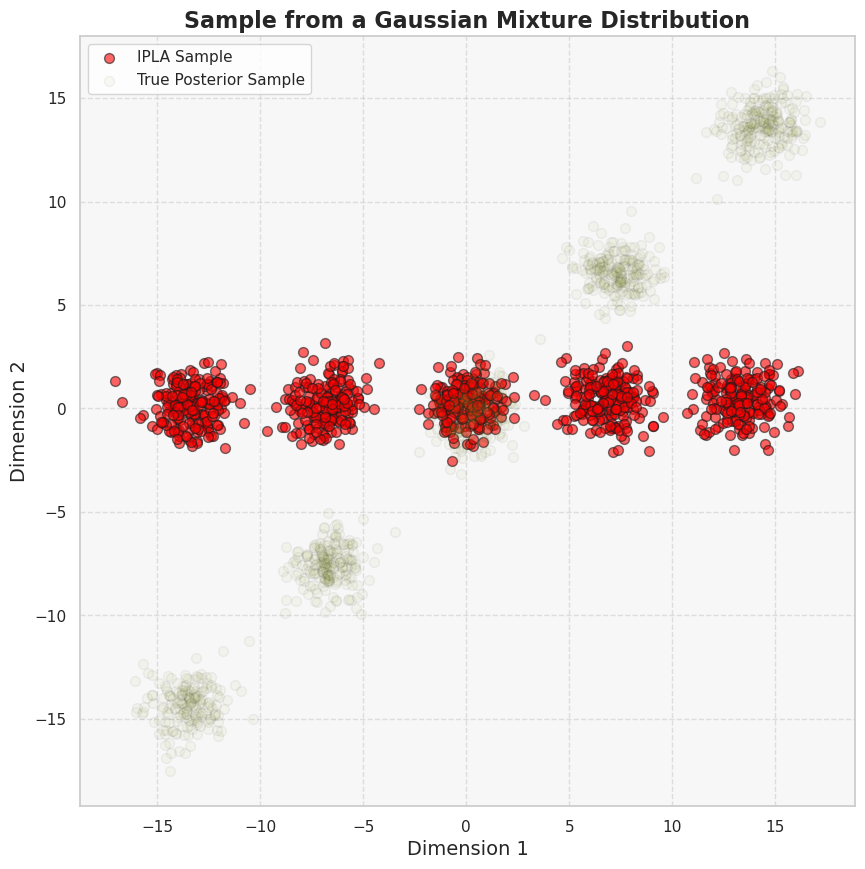

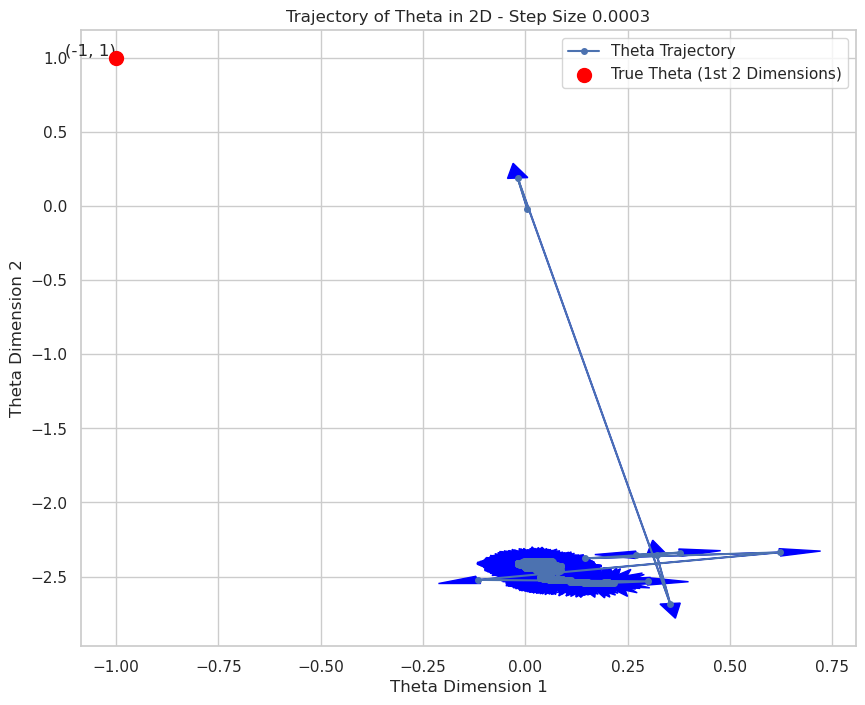

At the end, the number of NaN in the final sample of particle is 0
[ 0.04499834 -2.43724982 -0.06156404 -2.38904232 -0.05177564 -2.46002929
  0.09083481 -2.6244649   0.03394849 -2.49897857]


In [470]:
## Initialization of theta at origin
theta_0 = np.zeros(10)
sigma_y = 0.1

final_sample, theta_estimated, theta_traj = IPLA_dx(1000, 8000, 0.0003, params_prior[0], params_prior[1], params_prior[2], theta_0, sigma_y, y_obs_dx, plot = True, plot_true_theta = theta_star)

print(theta_estimated)

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
### IPLA with Dilation Path

(...)

In [665]:

def IPLA_Dilation_Adapt_dx(nb_particles, nb_iter, centers_prior, covariances_prior, weights_prior, theta_0, sigma_y, y_obs, start_schedule, end_schedule, 
                           alpha = 1, bound = 100, plot = False, plot_true_theta = None) : 
    """
    This function executes the Particle Gradient Descent in the context of our experiment. Given :
    - The number of particles
    - The number of iterations
    - The step size
    - Parameters of the prior distribution
    - The observed data point "y"
    - The initializing theta_0
    """

    theta_t = theta_0

    dx = theta_0.shape[0]

    sample = sample_prior_dx(nb_particles, centers_prior, covariances_prior, weights_prior)

    time_SDE = np.zeros(nb_particles)

    step_tab = np.full(nb_particles, start_schedule)

    theta_traj = np.zeros((nb_iter, dx))

    for i in tqdm(range(nb_iter)): 

        time_SDE += step_tab

        schedule = np.minimum(end_schedule, time_SDE) / end_schedule

        gamma = 1 / np.sqrt(schedule)

        gamma_sample = gamma[:, np.newaxis] * sample
        
        grad = ((1/sigma_y**2) * theta_t[:, np.newaxis] * (y_obs - np.dot(theta_t, gamma_sample.T))).T 

        grad += grad_multimodal_opti(gamma_sample, weights_prior, centers_prior, covariances_prior)

        grad = gamma[:, np.newaxis] * grad

        step_tab = np.minimum(1 / (np.linalg.norm(grad, axis = 1) + 1e-8), bound) * alpha #Vecteur de taille nb_particles qui donne le step pour chaque particle à cette itération

        noise = np.sqrt(2 * step_tab)[:, np.newaxis] * np.random.randn(nb_particles, dx)

        grad_update = step_tab[:, np.newaxis] * grad

        sample += grad_update + noise


        #MAJ THETA we need a fct that compute gradient of the potential wrt to theta

        grad_theta = grad_theta_GM(sample, theta_t, y_obs, sigma_y) #renvoie un vecteur avec tous les gradients

        grad_theta_update = np.sum(grad_theta, axis = 0) ## ON MULTIPLIE CHAQUE PARTICLE A SON PAS SPECIFIQUE

        theta_noise = np.sqrt(2 * alpha / nb_particles) * np.random.randn(dx)

        theta_t = theta_t - (alpha / nb_particles) * grad_theta_update + theta_noise

        theta_traj[i] = theta_t

        if np.sum(np.isnan(sample)) // dx > 850:

            print('Too many NaN in the sample')
            
            return sample, theta_t, theta_traj

    if plot : 

        centers_post, covariances_post, weights_post = post_params_dx(plot_true_theta, sigma_y, centers_prior, covariances_prior, weights_prior, y_obs)
        
        sample_post = sample_prior_dx(1000, centers_post, covariances_post, weights_post)
        
        plot_sample_dx(sample, "IPLA Sample", sample_post, "True Posterior Sample")

        #plot
        plt.figure(figsize=(10, 8))

        plt.plot(theta_traj[:, 0], theta_traj[:, 1], 'o-', markersize=4, label='Theta Trajectory')

        for i in range(1, len(theta_traj)):

            plt.arrow(theta_traj[i-1, 0], theta_traj[i-1, 1], 
                    theta_traj[i, 0] - theta_traj[i-1, 0], 
                    theta_traj[i, 1] - theta_traj[i-1, 1], 
                    head_width=0.05, head_length=0.1, fc='blue', ec='blue')
            
        plt.scatter(plot_true_theta[0], plot_true_theta[1], color='red', s=100, zorder=5, label='True Theta (1st 2 Dimensions)')
        plt.text(plot_true_theta[0], plot_true_theta[1], s = f"({plot_true_theta[0]}, {plot_true_theta[1]})" , fontsize=12, verticalalignment='bottom', horizontalalignment='right')

        plt.xlabel('Theta Dimension 1')
        plt.ylabel('Theta Dimension 2')
        plt.title(f'Trajectory of Theta in 2D - Step Size {step_size}')
        plt.legend()
        plt.grid(True)
        plt.show() 

    print(f'At the end, the number of NaN in the final sample of particle is {np.sum(np.isnan(sample)) // dx}')

    return sample, theta_t, theta_traj

100%|██████████| 800/800 [00:10<00:00, 77.39it/s] 


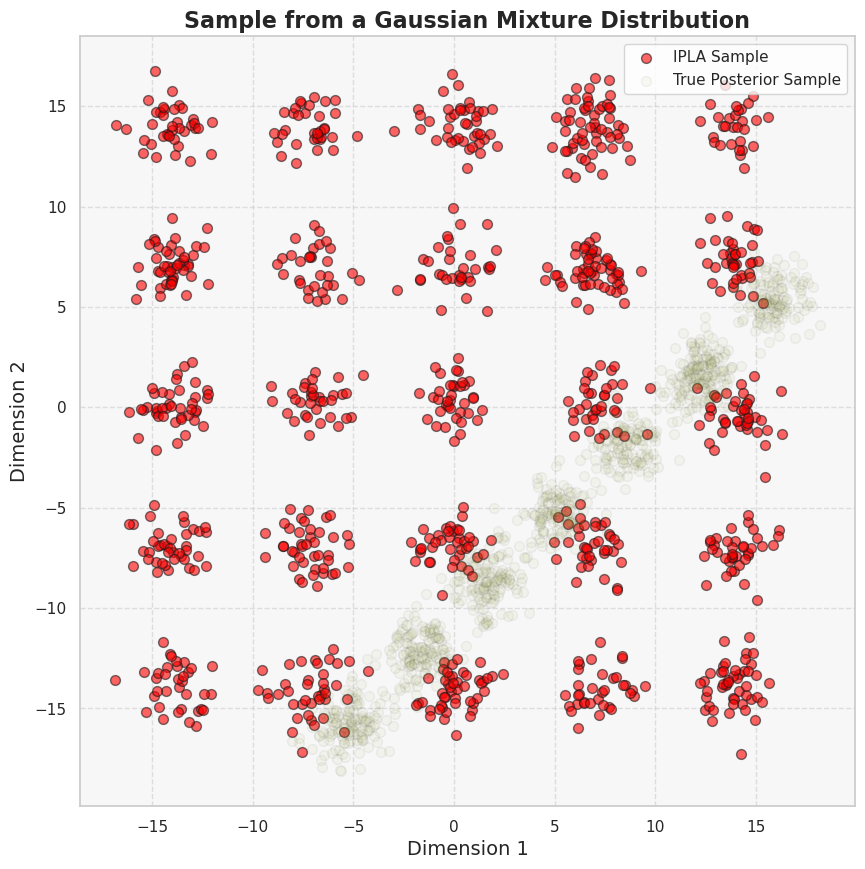

NameError: name 'step_size' is not defined

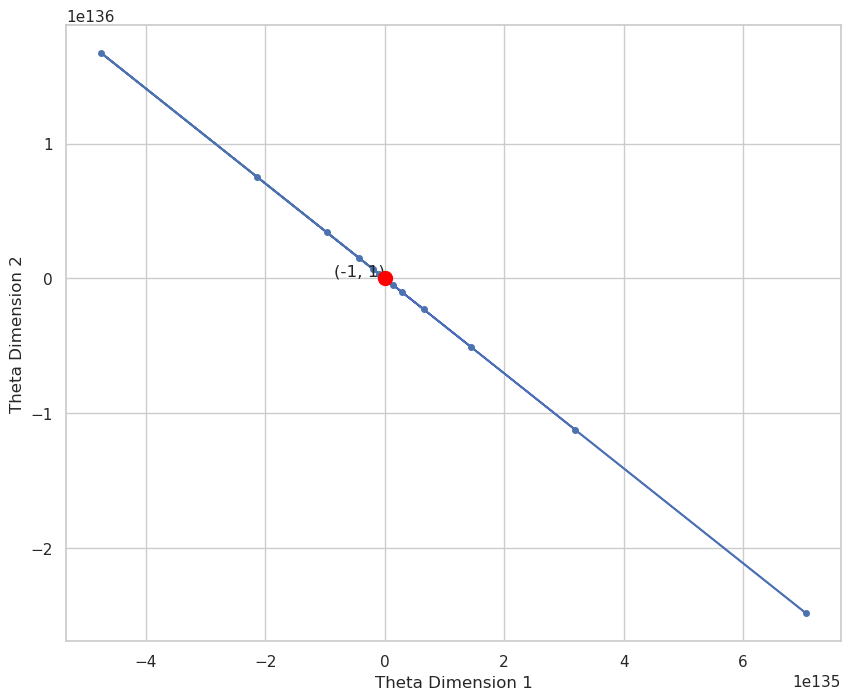

In [677]:
## Initialization of theta at origin
theta_0 = np.zeros(10)
sigma_y = 0.1

final_sample, theta_estimated, theta_traj = IPLA_Dilation_Adapt_dx(1000, 800, params_prior[0], params_prior[1], params_prior[2], theta_0, sigma_y, y_obs_dx, 1, 1, alpha = 0.00005, bound = 100, plot = True, plot_true_theta = theta_star)

print(theta_estimated)

Deuxieme exemple a posterior plus complexe : 

In [597]:
x_star = sample_prior_dx(1, params[0], params[1], params[2])

theta_star = np.tile([2, 0], 5)

y_obs_dx = generate_obs_dx(x_star, theta_star, 0.1)
y_obs_dx

array([197.20641672])

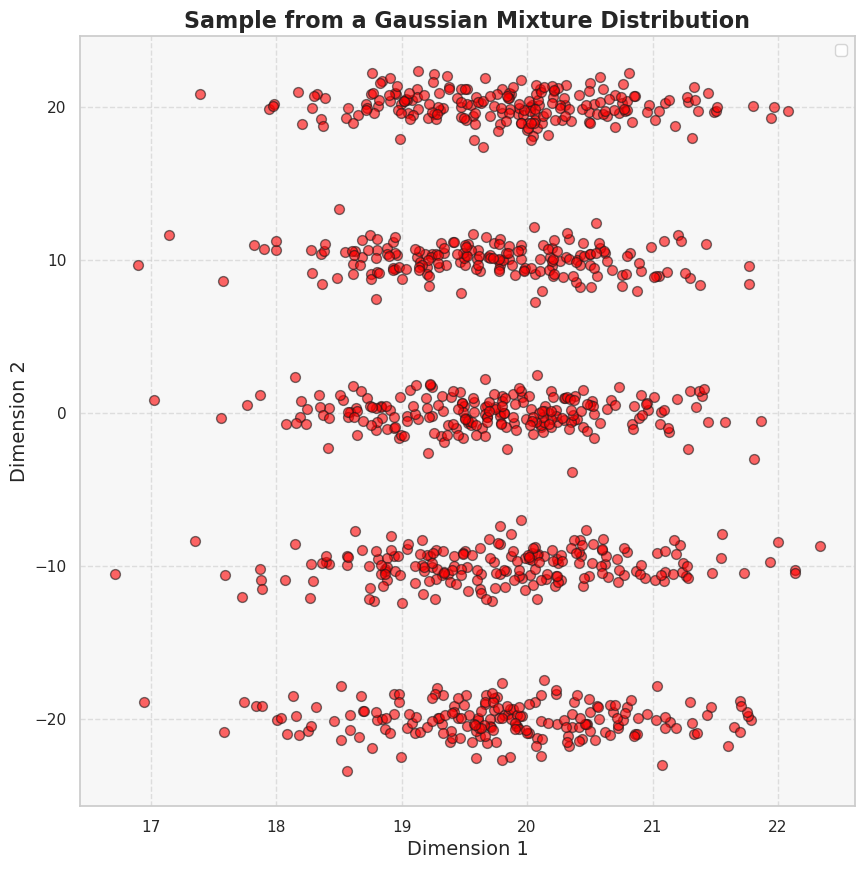

In [598]:
centers_posteriori, covariances_posteriori, weights_posteriori = post_params_dx(theta_star, 0.1, params[0], params[1], params[2], y_obs_dx)

sample_post = sample_prior_dx(1000, centers_posteriori, covariances_posteriori, weights_posteriori)

plot_sample_dx(sample_post)

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:24<00:00, 82.40it/s]


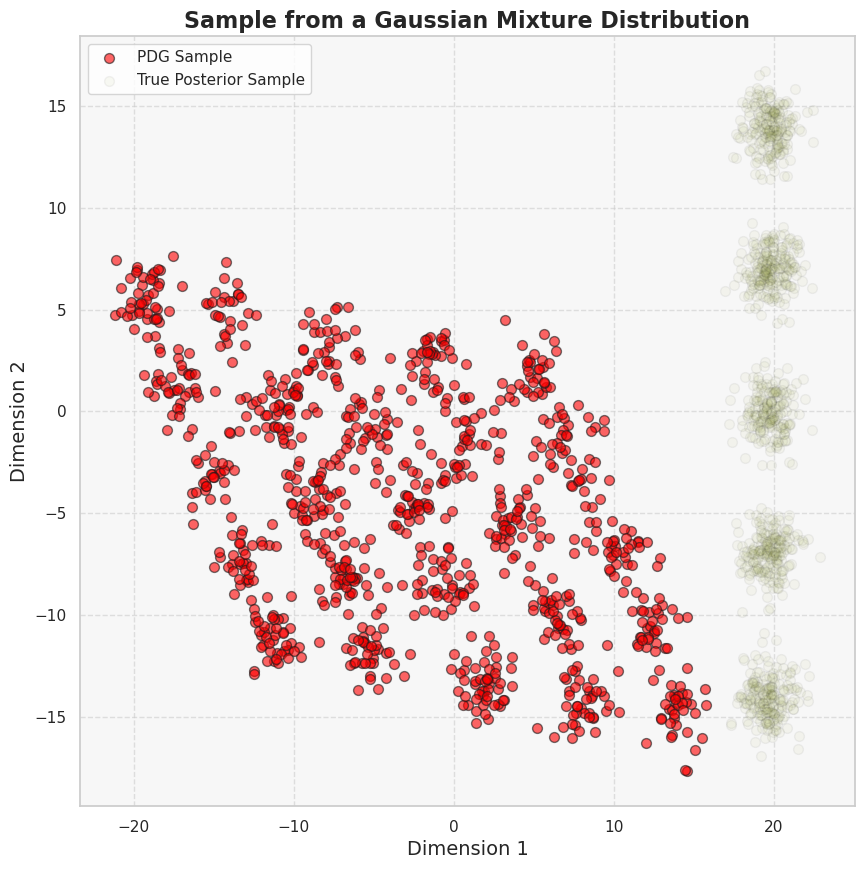

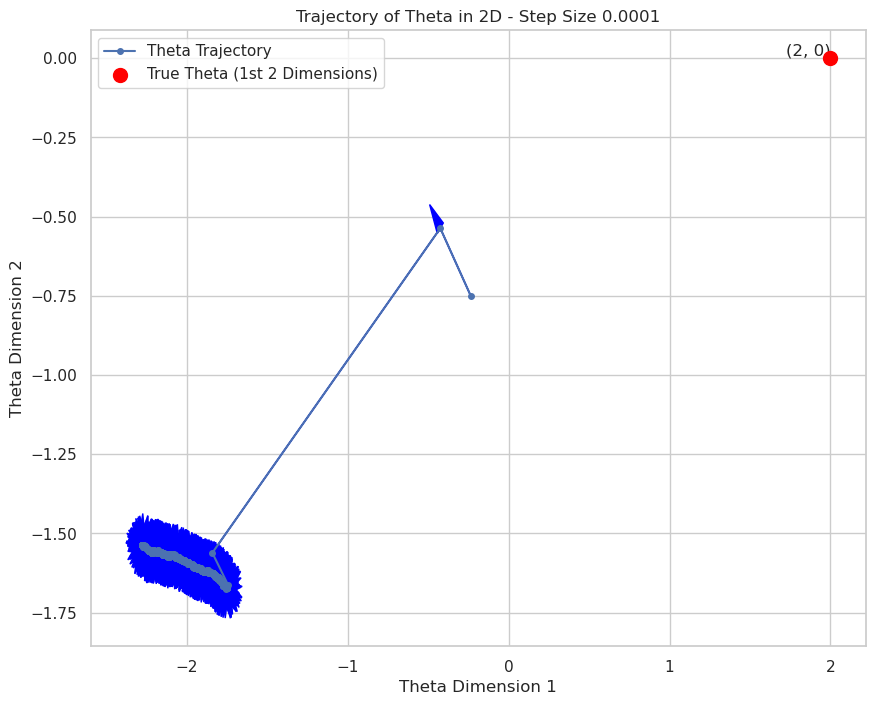

At the end, the number of NaN in the final sample of particle is 0


  0%|          | 6/2000 [00:00<00:24, 82.98it/s]


Too many NaN in the sample


  0%|          | 8/2000 [00:00<00:32, 60.39it/s]


Too many NaN in the sample


 49%|████▊     | 973/2000 [00:13<00:13, 74.23it/s] 


Too many NaN in the sample


  0%|          | 7/2000 [00:00<00:24, 81.14it/s]


Too many NaN in the sample


  0%|          | 7/2000 [00:00<00:24, 82.20it/s]


Too many NaN in the sample


  0%|          | 10/2000 [00:00<00:24, 81.57it/s]


Too many NaN in the sample


  0%|          | 7/2000 [00:00<00:24, 80.80it/s]


Too many NaN in the sample


  0%|          | 8/2000 [00:00<00:25, 78.25it/s]

Too many NaN in the sample
[nan nan nan nan nan nan nan nan nan nan]


In [645]:
## Initialization of theta at origin
theta_0 = np.zeros(10)
sigma_y = 0.1

final_sample, theta_estimated, theta_traj = PGD_dx(1000, 2000, 0.0001, params_prior[0], params_prior[1], params_prior[2], theta_0, sigma_y, y_obs_dx, plot = True, plot_true_theta = theta_star)

print(theta_estimated)

100%|██████████| 2000/2000 [00:26<00:00, 75.33it/s]


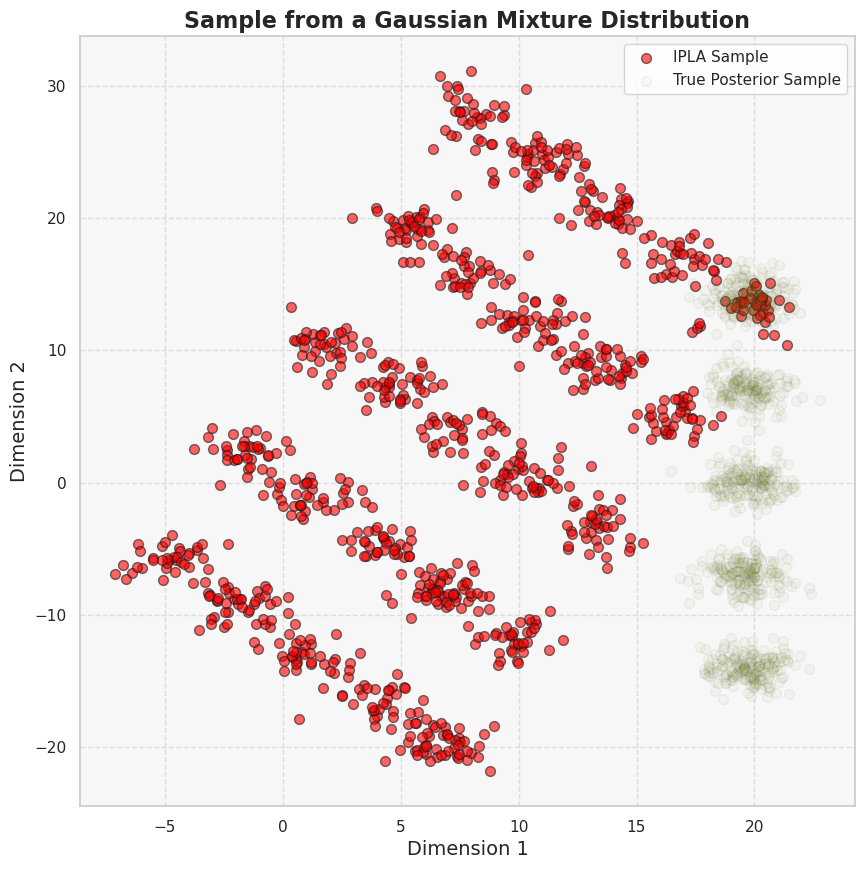

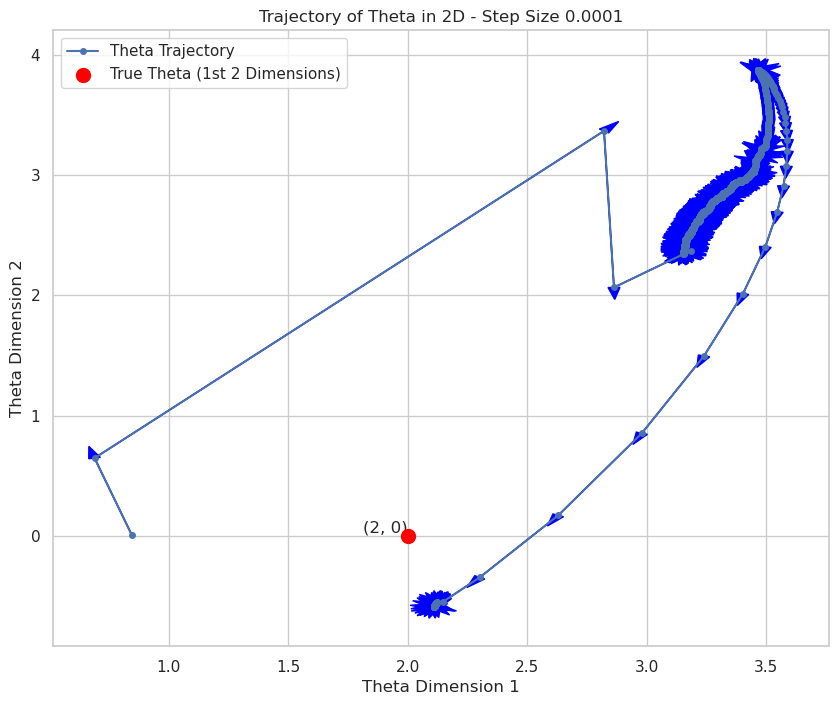

At the end, the number of NaN in the final sample of particle is 0


  0%|          | 8/2000 [00:00<00:23, 85.45it/s]


Too many NaN in the sample


  0%|          | 6/2000 [00:00<00:24, 81.14it/s]


Too many NaN in the sample


  0%|          | 7/2000 [00:00<00:17, 112.05it/s]


Too many NaN in the sample


  0%|          | 6/2000 [00:00<00:23, 85.37it/s]


Too many NaN in the sample


  0%|          | 7/2000 [00:00<00:25, 77.54it/s]


Too many NaN in the sample


  0%|          | 7/2000 [00:00<00:23, 83.82it/s]


Too many NaN in the sample


  1%|          | 22/2000 [00:00<00:21, 93.82it/s]


Too many NaN in the sample


  1%|          | 13/2000 [00:00<00:23, 86.10it/s]


Too many NaN in the sample


  1%|          | 11/2000 [00:00<00:22, 89.90it/s]


Too many NaN in the sample


  0%|          | 5/2000 [00:00<00:36, 55.04it/s]


Too many NaN in the sample


  0%|          | 7/2000 [00:00<00:30, 66.03it/s]

Too many NaN in the sample
[nan nan nan nan nan nan nan nan nan nan]


In [641]:
## Initialization of theta at origin
theta_0 = np.zeros(10)
sigma_y = 0.1

final_sample, theta_estimated, theta_traj = IPLA_dx(1000, 2000, 0.0001, params_prior[0], params_prior[1], params_prior[2], theta_0, sigma_y, y_obs_dx, plot = True, plot_true_theta = theta_star)

print(theta_estimated)